In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.vector_ar.var_model import VAR
%matplotlib inline

## Preprocessing

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19 testing data
testing = pd.read_csv('https://covidtracking.com/data/download/california-history.csv')
testing.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2020-12-07,CA,B,19935.0,NaN,59,NaN,NaN,NaN,10998.0,0,NaN,2470.0,24126916,273570,NaN,NaN,NaN,NaN,NaN,1366435,1366435.0,24735,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,25493351,298305,NaN,NaN,NaN,NaN,NaN,0,25493351,298305
1,2020-12-06,CA,B,19876.0,NaN,85,NaN,NaN,NaN,10624.0,0,NaN,2393.0,23853346,262996,NaN,NaN,NaN,NaN,NaN,1341700,1341700.0,30075,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,25195046,293071,NaN,NaN,NaN,NaN,NaN,0,25195046,293071
2,2020-12-05,CA,B,19791.0,NaN,209,NaN,NaN,NaN,10273.0,0,NaN,2265.0,23590350,201429,NaN,NaN,NaN,NaN,NaN,1311625,1311625.0,25068,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24901975,226497,NaN,NaN,NaN,NaN,NaN,0,24901975,226497
3,2020-12-04,CA,B,19582.0,NaN,145,NaN,NaN,NaN,9948.0,0,NaN,2248.0,23388921,178818,NaN,NaN,NaN,NaN,NaN,1286557,1286557.0,22018,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24675478,200836,NaN,NaN,NaN,NaN,NaN,0,24675478,200836
4,2020-12-03,CA,B,19437.0,NaN,113,NaN,NaN,NaN,9702.0,0,NaN,2147.0,23210103,156925,NaN,NaN,NaN,NaN,NaN,1264539,1264539.0,18591,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24474642,175516,NaN,NaN,NaN,NaN,NaN,0,24474642,175516


In [3]:
# Hospital data by county if needed
hospital_url = 'https://data.ca.gov/dataset/529ac907-6ba1-4cb7-9aae-8966fc96aeef/resource/42d33765-20fd-44b8-a978-b083b7542225/download/hospitals_by_county.csv'
hospital_df = pd.read_csv(hospital_url)

In [4]:
# recovery data?
testing['recovered'].unique()

array([nan])

In [5]:
testing = testing[['date', 'totalTestResults', 'totalTestResultsIncrease']]
testing.rename(columns={'totalTestResults': 'total_tests', 'totalTestResultsIncrease': 'new_tests'}, inplace=True)
testing = testing.sort_values(by='date', ascending=True).reset_index(drop=True)
testing.head()

,date,total_tests,new_tests
0,2020-03-04,515,0
1,2020-03-05,515,0
2,2020-03-06,522,7
3,2020-03-07,531,9
4,2020-03-08,550,19


In [6]:
# NY Times time series
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes = pd.read_csv(url)
nytimes = nytimes.loc[(nytimes['date'] >= '2020-03-04') &
                      (nytimes['state'] == 'California')].reset_index(drop=True)
nytimes.head()

,date,state,fips,cases,deaths
0,2020-03-04,California,6,55,1
1,2020-03-05,California,6,67,1
2,2020-03-06,California,6,81,1
3,2020-03-07,California,6,100,1
4,2020-03-08,California,6,112,1


In [7]:
# merge testing data and NY Times data
df = pd.merge(testing, nytimes, how='inner', on='date')
df.drop(['state', 'fips'], axis=1, inplace=True)
df.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
df.head()

,date,total_tests,new_tests,total_cases,total_deaths
0,2020-03-04,515,0,55,1
1,2020-03-05,515,0,67,1
2,2020-03-06,522,7,81,1
3,2020-03-07,531,9,100,1
4,2020-03-08,550,19,112,1


In [8]:
# create daily cases and daily deaths columns
df['new_cases'] = df['total_cases'].diff()
df['new_deaths'] = df['total_deaths'].diff()
df.fillna(0, inplace=True)
df['new_cases'] = df['new_cases'].astype('int')
df['new_deaths'] = df['new_deaths'].astype('int')
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-04,515,0,55,1,0,0
1,2020-03-05,515,0,67,1,12,0
2,2020-03-06,522,7,81,1,14,0
3,2020-03-07,531,9,100,1,19,0
4,2020-03-08,550,19,112,1,12,0


In [9]:
# add positivity rate column
df['positivity_rate'] = df['total_cases']/df['total_tests']
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


In [10]:
df.to_csv('california_covid19.csv')
print(df.shape)
df.head()

(279, 8)


,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


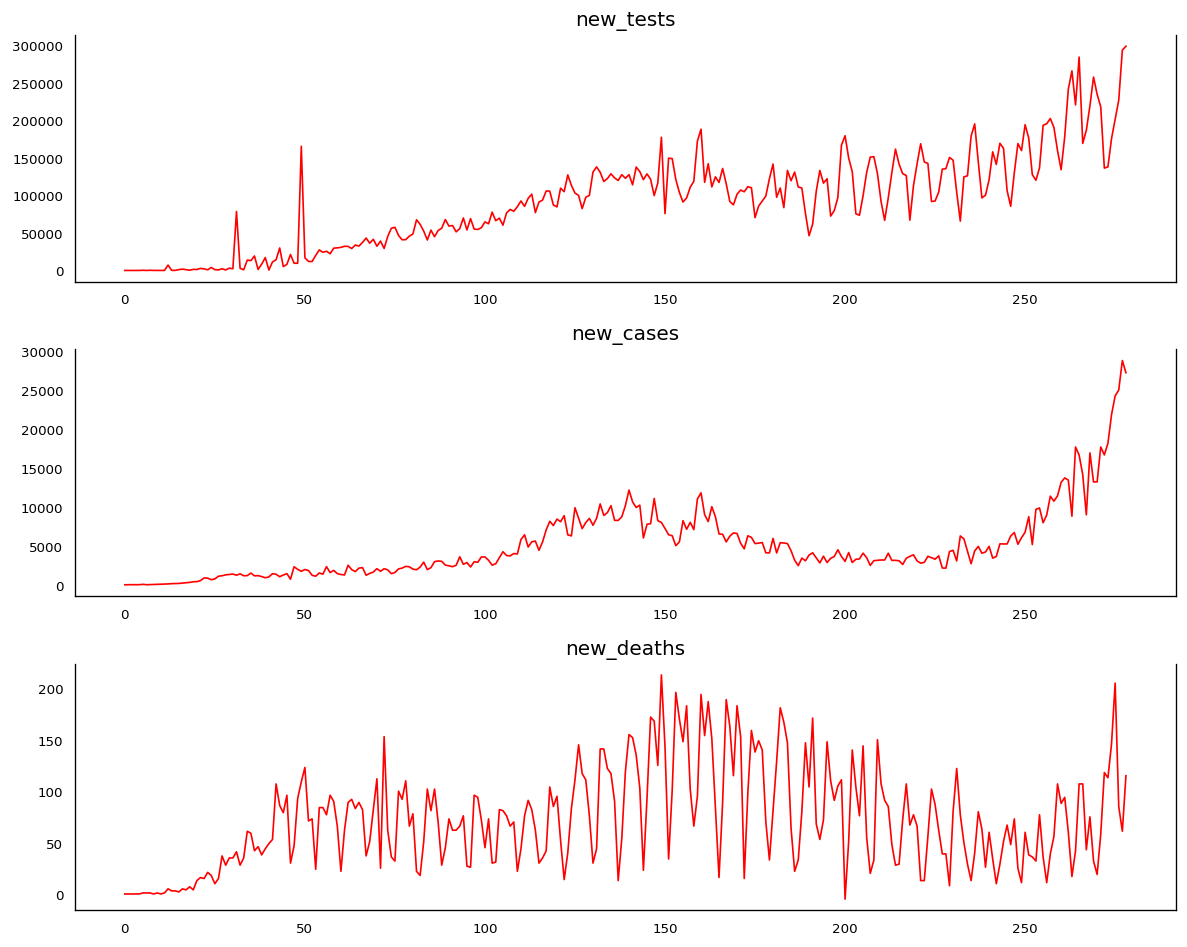

In [11]:
plot_df = df.loc[:, ['new_tests', 'new_cases', 'new_deaths']]
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,8))
plt.rc('font', size=10)
for i, ax in enumerate(axes.flatten()): 
    data = plot_df[plot_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(plot_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.tight_layout()

## Correlation

In [12]:
# Our null hypothesis is that the correlation coefficient is not significantly different from 0.
def pearson_corr(column1, column2):
    corr_coef, p_value = pearsonr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)

def spearman_corr(column1, column2):
    corr_coef, p_value = spearmanr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)
    
pearson_corr(df['new_cases'], df['new_deaths'])

correlation: 0.37250758803158296
p value: 1.30185385202683e-10


P-value is less than 0.05, so we can conclude there is a positive correlation between new deaths and new cases.

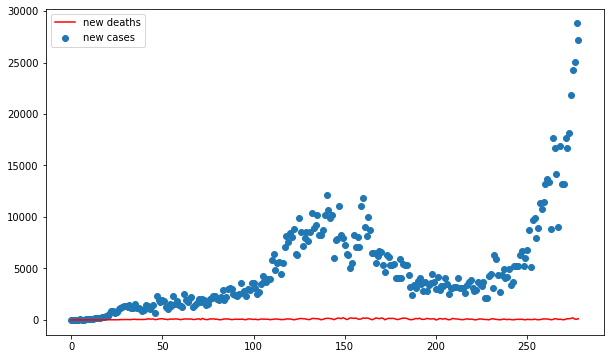

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, len(df)), df['new_cases'], label='new cases')
plt.plot(np.arange(0, len(df)), df['new_deaths'], label='new deaths', c='red')
plt.legend()
plt.show()

In [14]:
pearson_corr(df['positivity_rate'], df['total_deaths'])

correlation: -0.5556701835808471
p value: 5.246341907567557e-24


In [15]:
df.corr(method='spearman')

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
total_tests,1.000000,0.875450,1.000000,0.999996,0.739289,0.267841,-0.822757
new_tests,0.875450,1.000000,0.875448,0.875437,0.796411,0.232238,-0.707594
total_cases,1.000000,0.875448,1.000000,0.999996,0.739291,0.267843,-0.822751
total_deaths,0.999996,0.875437,0.999996,1.000000,0.739306,0.267972,-0.822793
new_cases,0.739289,0.796411,0.739291,0.739306,1.000000,0.465520,-0.590941
new_deaths,0.267841,0.232238,0.267843,0.267972,0.465520,1.000000,-0.072845
positivity_rate,-0.822757,-0.707594,-0.822751,-0.822793,-0.590941,-0.072845,1.000000


## Validation Models

In [16]:
cases_df = df[['new_tests', 'total_cases', 'new_cases', 'new_deaths', 'positivity_rate']]
cases_df.shape

(279, 5)

In [17]:
cases_df = cases_df.iloc[0:151]
cases_df.head()

,new_tests,total_cases,new_cases,new_deaths,positivity_rate
0,0,55,0,0,0.106796
1,0,67,12,0,0.130097
2,7,81,14,0,0.155172
3,9,100,19,0,0.188324
4,19,112,12,0,0.203636


### Cases

In [18]:
cases_model = VAR(cases_df)
model_fit = cases_model.fit()
prediction = model_fit.forecast(model_fit.y, steps=50)
model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Dec, 2020
Time:                     10:53:40
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    12.7871
Nobs:                     150.000    HQIC:                   12.4296
Log likelihood:          -1948.07    FPE:                    195858.
AIC:                      12.1849    Det(Omega_mle):         66232.3
--------------------------------------------------------------------
Results for equation new_tests
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                  24242.460023      5515.122307            4.396           0.000
L1.new_tests               0.143231         0.089617            1.598           0.110
L1.total_cases             0.120604 

In [19]:
pred_df = pd.DataFrame(prediction, columns=cases_df.columns)
pred_df.head()

,new_tests,total_cases,new_cases,new_deaths,positivity_rate
0,119034.348012,517205.850866,7698.850866,134.903113,0.068220
1,129300.367243,525705.329546,8499.478680,135.893488,0.062491
2,136750.614991,534881.413121,9176.083574,137.030613,0.056212
3,143203.514460,544625.295356,9743.882235,138.233202,0.050079
4,148942.723426,554856.002475,10230.707119,139.619511,0.044231


In [20]:
#pred_df['total_tests'] = pred_df['total_tests'].astype('int64')
pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
pred_df['total_cases'] = pred_df['total_cases'].astype('int64')
pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
pred_df['date_range'] = np.arange(len(cases_df), len(cases_df)+len(pred_df))
pred_df['date'] = pd.date_range(start=df['date'][151], periods=len(pred_df), freq='D')
print(pred_df.shape)
pred_df.head()

(50, 7)


,new_tests,total_cases,new_cases,new_deaths,positivity_rate,date_range,date
0,119034,517205,7698,134.903113,0.068220,151,2020-08-02
1,129300,525705,8499,135.893488,0.062491,152,2020-08-03
2,136750,534881,9176,137.030613,0.056212,153,2020-08-04
3,143203,544625,9743,138.233202,0.050079,154,2020-08-05
4,148942,554856,10230,139.619511,0.044231,155,2020-08-06


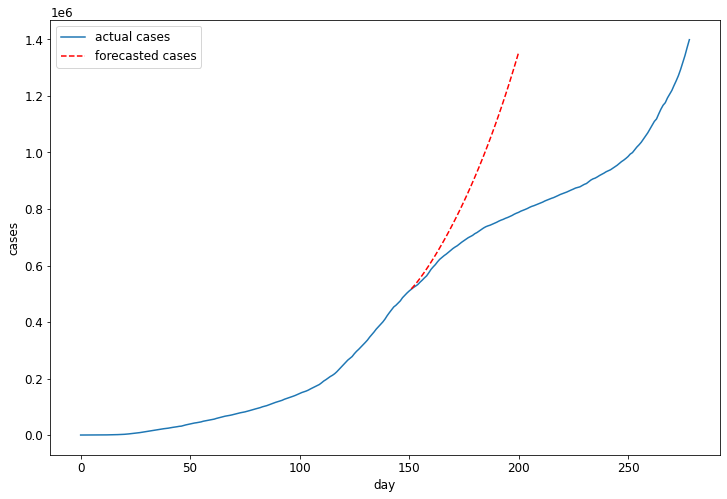

In [21]:
plt.figure(figsize=(12,8))
plt.rc('font', size=12)
plt.plot(np.arange(0, len(df)), df['total_cases'], label='actual cases')
plt.plot(pred_df['date_range'], pred_df['total_cases'], '--', label='forecasted cases', c='red')
plt.xlabel('day')
plt.ylabel('cases')
plt.legend()
plt.show()

### Deaths

In [22]:
deaths_df = df[['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']]
deaths_df = deaths_df.iloc[1:151]
deaths_df.head()

,new_tests,total_deaths,new_cases,new_deaths,positivity_rate
1,0,1,12,0,0.130097
2,7,1,14,0,0.155172
3,9,1,19,0,0.188324
4,19,1,12,0,0.203636
5,254,2,60,1,0.213930


In [23]:
deaths_model = VAR(deaths_df)
model_fit = deaths_model.fit()
prediction = model_fit.forecast(model_fit.y, steps=50)
model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Dec, 2020
Time:                     10:53:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    5.82719
Nobs:                     149.000    HQIC:                   5.46810
Log likelihood:          -1416.18    FPE:                    185.414
AIC:                      5.22237    Det(Omega_mle):         146.071
--------------------------------------------------------------------
Results for equation new_tests
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                   3614.271020      5535.952586            0.653           0.514
L1.new_tests              -0.053197         0.084907           -0.627           0.531
L1.total_deaths           12.257343 

In [24]:
pred_df = pd.DataFrame(prediction, columns=deaths_df.columns)
pred_df.head()

,new_tests,total_deaths,new_cases,new_deaths,positivity_rate
0,132085.331309,9481.315659,7196.752291,116.315659,0.037119
1,132817.326217,9595.825273,7795.725684,114.509614,0.018270
2,136816.641799,9710.417627,8243.937492,114.592354,0.006382
3,139853.981023,9826.410951,8617.046618,115.993324,-0.001334
4,142534.562039,9944.139294,8927.170525,117.728343,-0.006465


In [25]:
pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
#pred_df['total_cases'] = pred_df['total_cases'].astype('int64')
pred_df['total_deaths'] = pred_df['total_deaths'].astype('int64')
pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
pred_df['new_deaths'] = pred_df['new_deaths'].astype('int64')
pred_df['date_range'] = np.arange(len(deaths_df), len(deaths_df)+len(pred_df))
pred_df['date'] = pd.date_range(start=df['date'][151], periods=len(pred_df), freq='D')
print(pred_df.shape)
pred_df.head()

(50, 7)


,new_tests,total_deaths,new_cases,new_deaths,positivity_rate,date_range,date
0,132085,9481,7196,116,0.037119,150,2020-08-02
1,132817,9595,7795,114,0.018270,151,2020-08-03
2,136816,9710,8243,114,0.006382,152,2020-08-04
3,139853,9826,8617,115,-0.001334,153,2020-08-05
4,142534,9944,8927,117,-0.006465,154,2020-08-06


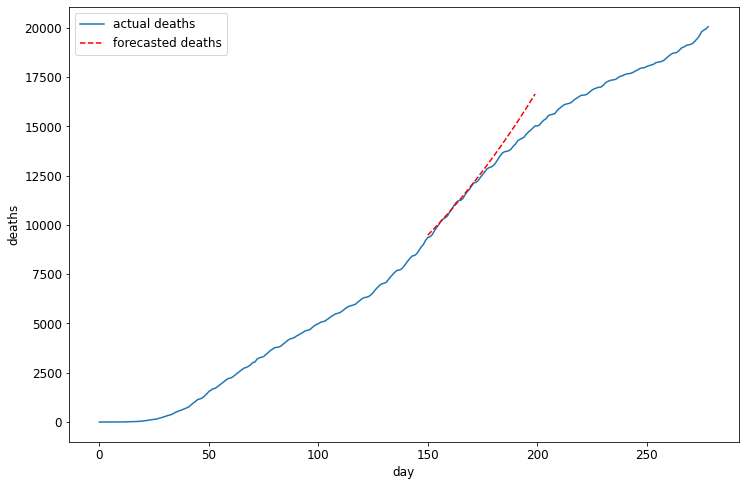

In [26]:
plt.figure(figsize=(12,8))
plt.rc('font', size=12)
plt.plot(np.arange(0, len(df)), df['total_deaths'], label='actual deaths')
plt.plot(pred_df['date_range'], pred_df['total_deaths'], '--', label='forecasted deaths', c='red')
plt.xlabel('day')
plt.ylabel('deaths')
plt.legend()
plt.show()

## Baseline Models

In [18]:
model = VAR(fit_df)
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=50)
#model.summary()
# build a model using only total cases, total deaths

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [19]:
pred_df = pd.DataFrame(prediction, columns=fit_df.columns)
pred_df.head()

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2.449055e+07,191420.294322,1.288937e+06,19542.517277,17028.757406,102.517277,0.066024
1,2.469405e+07,203501.099325,1.305627e+06,19643.693420,16689.948133,101.176143,0.076287
2,2.489908e+07,205030.739832,1.322150e+06,19745.249182,16523.409992,101.555762,0.085041
3,2.510311e+07,204029.296019,1.338554e+06,19847.464497,16404.370748,102.215314,0.092954
4,2.530561e+07,202499.570548,1.354858e+06,19950.414523,16303.314189,102.950026,0.100305


In [20]:
pred_df['total_tests'] = pred_df['total_tests'].astype('int64')
pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
pred_df['total_cases'] = pred_df['total_cases'].astype('int64')
pred_df['total_deaths'] = pred_df['total_deaths'].astype('int64')
pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
pred_df['new_deaths'] = pred_df['new_deaths'].astype('int64')
pred_df['date_range'] = np.arange(len(fit_df), len(fit_df)+len(pred_df))
pred_df['date'] = pd.date_range(start=df['date'].max(), periods=len(pred_df), freq='D')
pred_df.head()

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate,date_range,date
0,24490546,191420,1288936,19542,17028,102,0.066024,274,2020-12-02
1,24694047,203501,1305626,19643,16689,101,0.076287,275,2020-12-03
2,24899078,205030,1322150,19745,16523,101,0.085041,276,2020-12-04
3,25103107,204029,1338554,19847,16404,102,0.092954,277,2020-12-05
4,25305607,202499,1354857,19950,16303,102,0.100305,278,2020-12-06


In [21]:
print('Model predicted', pred_df['total_cases'].max(), 'cases in California by', pred_df['date'].max())

Model predicted 2063422 cases in California by 2021-01-20 00:00:00


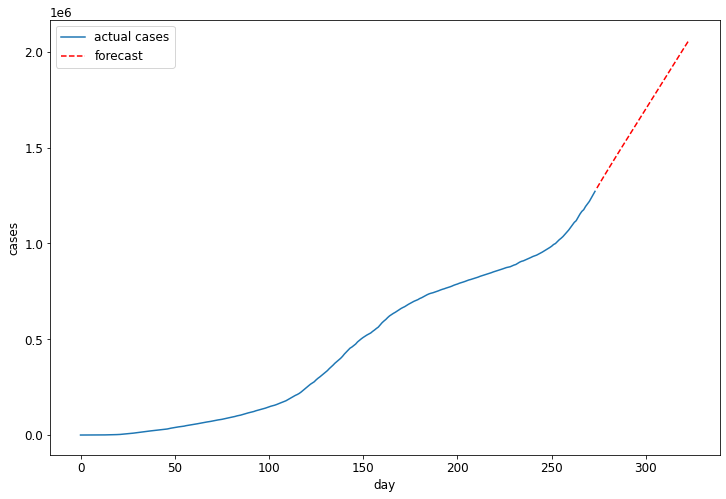

In [22]:
plt.figure(figsize=(12,8))
plt.rc('font', size=12)
plt.plot(np.arange(0, len(fit_df)), fit_df['total_cases'], label='actual cases')
plt.plot(pred_df['date_range'], pred_df['total_cases'], '--', label='forecast', c='red')
plt.xlabel('day')
plt.ylabel('cases')
plt.legend()
plt.show()

## County Data

In [23]:
# url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
# url = 'https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv'
# df = pd.read_csv(url)
# df.rename(columns={'totalcountconfirmed': 'total_cases', 'totalcountdeaths': 'total_deaths', 
#                    'newcountconfirmed': 'new_cases', 'newcountdeaths': 'new_deaths'}, inplace=True)
# df.head()

In [24]:
# def create_county_data(county_name):
#     county = df.loc[df['county'] == county_name].reset_index(drop=True)
#     county['day'] = np.arange(0, len(county['date']))
#     return county

# sample = create_county_data('Los Angeles')
# sample